<div id="container" style="position:relative;">
<div style="float:left"><h1> Data Cleaning </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

Data cleaning sounds like an unglamorous task, but in reality, it is one of the most important things you will do in data science.  The fanciest machine learning algorithms will produce worthless models if your data isn't clean.  What do we mean by "clean"?  Broadly speaking, we mean that the data accurately represents what it claims to, and is formatted in a way that we can use our tools on it.  The data cleaning topics we're going to explore include:
* Formatting - is our data presented in a way that makes sense?  Are the variable types correct? (e.g. is there a column of strings that are supposed to represent numbers?)
* Outliers - for numerical datasets, are there any data points which differ greatly in value from most of the others that will affect the model?  (e.g. does the price value jump from 91 to 920 to 91.5 over three seconds?).    
* Missing data - are there any rows or columns that have blank, `np.NaN`, or otherwise missing data?  Should they be cut out?  If the dataset is time-series, should we fill using nearby data?
* Extra data - more common in time-series, has some process filled missing data already in a way that causes issues?
* Repeated data / indices - are there any duplicates in our data where there shouldn't be?  Does a customer have two separate addresses listed when each should only have one?  For daily data, do any days appear more than once?
* Re-indexing -  does the index accurately represent the dataset?  Is it numerical when it should be datetime?
* Data pre-processing - more accurately something to do after the data is "clean", do we need to add anything to the data that we need to use?  Should we create a flag to find out when two data fields match each other?  Do we need to add any computational indicators?

As a visual example, if we know a specific set of financial instrument prices are supposed to look like this:

<img src="https://drive.google.com/uc?export=view&id=10d0G0H07pD3pjqGwslbEyN_6Sn9PRU28 " width="400" height ="400"/>

then we can't try to create a model if the data we receive looks like this:

 <img src="https://drive.google.com/uc?export=view&id=1vEvuTR-IqUsplyU5gGKq-wQ2d1o6af8x " width="400" height ="400"/>

We need to figure out what problems are present, and the answers are not always obvious.

We'll return to using visualization as a data cleaning tool in a future unit, but for now we will use the Pandas tools we've already learned.  

Let us load in the dataset provided, `cleaning_data.csv`. This file can be found under this lesson in Synapse.

## Example 1

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

pd.options.mode.chained_assignment = None

# This last line of code is because Pandas can be a bit... overzealous with warnings, and some 
# of the exercises presented here raised "chained assignment" warnings unnecessarily.

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('data/cleaning_data.csv')
df

,index,name,Unnamed: 2,age,Debt
0,1,Mearcred,25,u25000,NaN
1,2,Winnifred,32,u15120,NaN
2,3,Cuthbert,50,u823,NaN
3,4,Horatius,35,u30125,NaN
4,5,Hereward,22,u995,NaN
5,6,Bysra,18,u5720,NaN


What are the first things we notice?  
1. There's an extra column called "index".  We should probably make that the index
2. The column called "age" has a collection of large numbers preceded by a 'u'.  This means their data type *isn't* a number.
3. There's a column that has no title, which seems to contain ages.
4. There's a column called "Debt" that has nothing in it.
5. All of the column names are lower case except for the last.

So, we can presume that the column names were shifted over one starting where age should be. Our first order of business will be to put the index right, reloading the dataframe:

In [3]:
df = pd.read_csv('cleaning_data.csv', index_col=0)
df

,name,Unnamed: 2,age,Debt
index,,,,
1,Mearcred,25,u25000,NaN
2,Winnifred,32,u15120,NaN
3,Cuthbert,50,u823,NaN
4,Horatius,35,u30125,NaN
5,Hereward,22,u995,NaN
6,Bysra,18,u5720,NaN


Well, that looks a little better, but now we have two rows of column titles.  We don't need the index to have a title, so we can remove that with the following command:

In [4]:
df.index.names = [None]
df

,name,Unnamed: 2,age,Debt
1,Mearcred,25,u25000,NaN
2,Winnifred,32,u15120,NaN
3,Cuthbert,50,u823,NaN
4,Horatius,35,u30125,NaN
5,Hereward,22,u995,NaN
6,Bysra,18,u5720,NaN


Now we need to change the column names to more accurately reflect the data present.  We saw we could call columns of a dataframe using the ```df.columns``` command:

In [5]:
df.columns

Index(['name', 'Unnamed: 2', 'age', 'Debt'], dtype='object')

But we can use this same command to rename the columns:

In [6]:
df.columns = ['Name', 'Age', 'Debt', ' ']
df

,Name,Age,Debt,
1,Mearcred,25,u25000,NaN
2,Winnifred,32,u15120,NaN
3,Cuthbert,50,u823,NaN
4,Horatius,35,u30125,NaN
5,Hereward,22,u995,NaN
6,Bysra,18,u5720,NaN


Since the last column is empty, we'll redefine our dataframe to only be the columns that have data:

In [7]:
df = df[['Name','Age','Debt']]
df

,Name,Age,Debt
1,Mearcred,25,u25000
2,Winnifred,32,u15120
3,Cuthbert,50,u823
4,Horatius,35,u30125
5,Hereward,22,u995
6,Bysra,18,u5720


This is starting to look better, but the Debt column should be numbers, and currently the data type is not numeric:

In [8]:
df['Debt']

1    u25000
2    u15120
3      u823
4    u30125
5      u995
6     u5720
Name: Debt, dtype: object

So how do we fix this?  Well, Pandas interpreted those data points as strings, so we could just slice out everything from the second character onwards.  Luckily, Pandas provides us with a number of tools to do these things efficiently by vectorizing a lot of common string commands using ```.str```:

In [3]:
df.dtypes #this is run from original df (not fixed yet)

index           int64
name           object
Unnamed: 2      int64
age            object
Debt          float64
dtype: object

In [9]:
df['Debt'].str[1:]

1    25000
2    15120
3      823
4    30125
5      995
6     5720
Name: Debt, dtype: object

So turning this column into numbers will be a two-step procedure:  
1. We'll redefine the column using this string-parsing method.
2. We'll use the Pandas function ```pd.to_numeric()``` change reasonable-looking data into numeric data-types.  

In [10]:
df['Debt'] = df['Debt'].str[1:]
df

,Name,Age,Debt
1,Mearcred,25,25000
2,Winnifred,32,15120
3,Cuthbert,50,823
4,Horatius,35,30125
5,Hereward,22,995
6,Bysra,18,5720


In [11]:
df['Debt'] = pd.to_numeric(df['Debt'])
df

,Name,Age,Debt
1,Mearcred,25,25000
2,Winnifred,32,15120
3,Cuthbert,50,823
4,Horatius,35,30125
5,Hereward,22,995
6,Bysra,18,5720


Now the dataset looks a lot cleaner, compared to where we started: the formats are all correct, the column names match the data, and it is properly indexed according to the file.  We could now confidently use this data.

## Outliers

Statistically speaking, an outlier is a data point with a value that differs substantially from other data points.  There are a number of reasons that outliers appear, including errors in data collection, and low-probability events in the sample. 
There is no precise definition for an "outlier", as the context inside each dataset is very important.  As a result, this means that observation is usually the first tool in addressing outliers.  We'll see in the upcoming units that there are also some statistical methods for dealing with outliers, depending on the distribution of the data.<br>
We'll start with a constructed example:

In [4]:
temps = pd.read_csv('data/temperature_cleaning.csv',index_col=0,parse_dates=True)
temps.head()

,Avg Daily Temp
2017-05-04,19
2017-05-05,23
2017-05-06,18
2017-05-07,22
2017-05-08,25


This is a dataset of average daily temperatures for May of 2017, in degrees Celsius.  Let's call the ```.describe()``` function to get an overview of the data:

In [13]:
temps.describe()

,Avg Daily Temp
count,27.000000
mean,28.740741
std,42.287107
min,17.000000
25%,18.500000
50%,20.000000
75%,23.000000
max,240.000000


We can immediately see an issue.  The standard deviation of the dataset is 42.2 (degrees Celsius), which is an immediate red flag.  We can also see that the max temperature in the set is apparently 240, which is likely an error.  Let's find all of the temperatures above 40 in the dataset:

In [14]:
temps[temps['Avg Daily Temp']>40]

,Avg Daily Temp
2017-05-11,240


This shows us that there is only one outlier.  We can slice out dates around it to see what the data's behavior is:

In [15]:
temps['2017-05-09':'2017-05-13']

,Avg Daily Temp
2017-05-09,20
2017-05-10,22
2017-05-11,240
2017-05-12,19
2017-05-13,23


Another way to check for outliers is a visual inspection, by plotting the data.

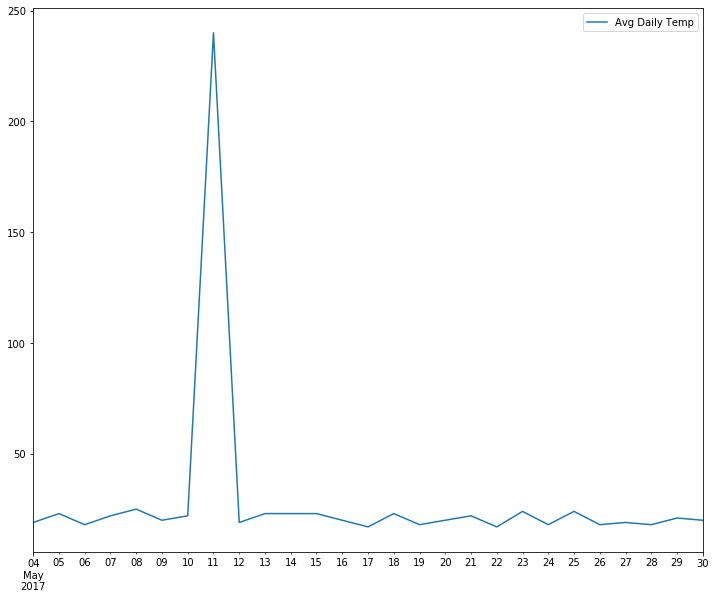

In [16]:
temps.plot();

This not only shows us where the spikes are, but gives us an overview of where they are in relation to the rest of the data.

The question of the best thing to do with an outlier, however, does not have a clear answer.  The temperature is listed as 240, and the median temperature of the data is 20; it's possible that this was a simple recording error, and that the real temperature is 24.  If you are confident in this, whether through consulting other sources, speaking with your team members, etc., you could change it like this:

In [17]:
t2 = temps.copy() # We'll make a copy so we can address another method.
temps.loc['2017-05-11','Avg Daily Temp'] = 24
temps['2017-05-09':'2017-05-13']

,Avg Daily Temp
2017-05-09,20
2017-05-10,22
2017-05-11,24
2017-05-12,19
2017-05-13,23


In [9]:
#do the same thing as above using iloc instead of loc
t3 = temps.copy() # We'll make a copy so we can address another method.
t3.iloc[7,0] = 24 # find the index by printing t3 then finding it the index or finding it using the for loop
t3['2017-05-09':'2017-05-13']

,Avg Daily Temp
2017-05-09,20
2017-05-10,22
2017-05-11,24
2017-05-12,19
2017-05-13,23


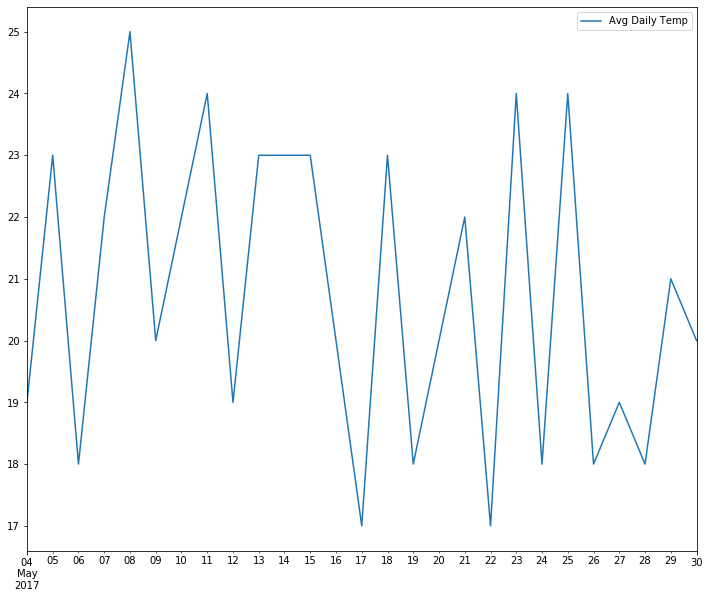

In [18]:
temps.plot();

If you were not confident about changing it, owing to not having additional sources, etc., your best bet would likely be to drop the data point entirely.  Having spurious data in your set will only weaken the models you make.  The easiest way to accomplish this is by redefining the dataframe using querying; we'll use the copy we made:

In [19]:
t2 = t2[t2['Avg Daily Temp']<40]
t2

,Avg Daily Temp
2017-05-04,19
2017-05-05,23
2017-05-06,18
2017-05-07,22
2017-05-08,25
2017-05-09,20
2017-05-10,22
2017-05-12,19
2017-05-13,23
2017-05-14,23


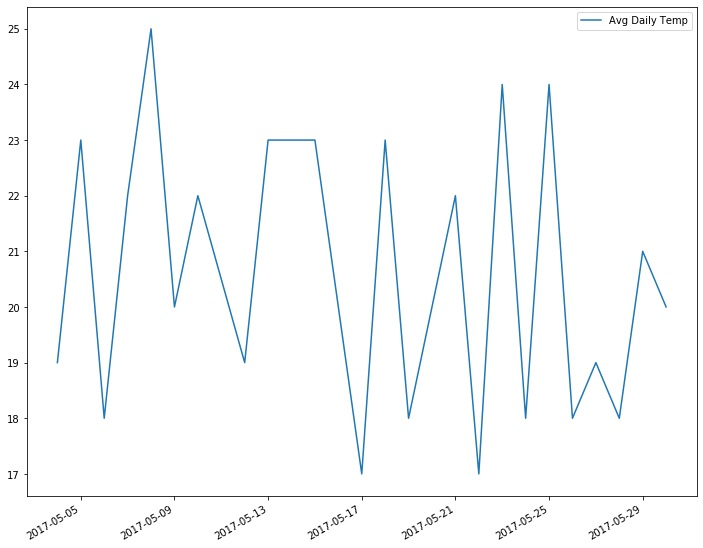

In [20]:
t2.plot();

Sometimes simple querying will not reveal where outliers are.  For example:

In [2]:
pc = pd.DataFrame({'Close Price':[42, 39, 35, 31, 29, 24, 22, 28, 28, 24, 22, 43, 23, 26, 22, 26, 28, 26, 24, 22 ]},
                  index=pd.date_range('2014-11-03',periods = 20,freq='D'))

In [3]:
pc.describe()

,Close Price
count,20.000000
mean,28.200000
std,6.606217
min,22.000000
25%,23.750000
50%,26.000000
75%,29.500000
max,43.000000


<AxesSubplot:>

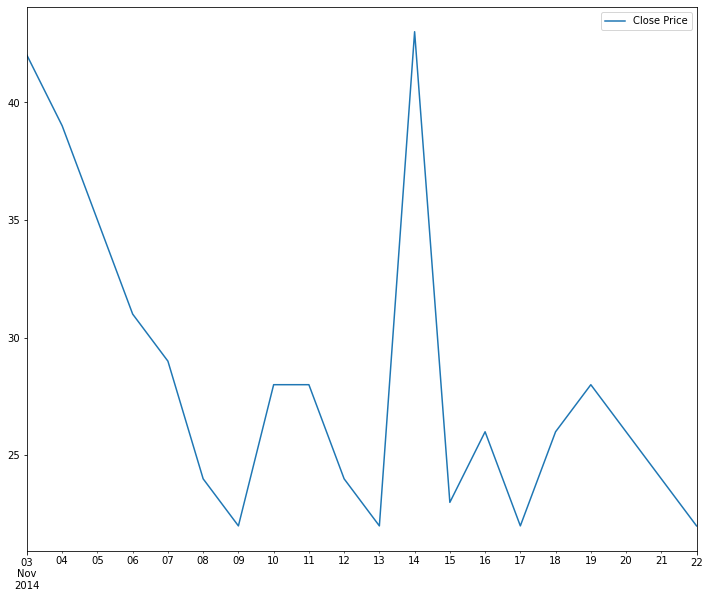

In [4]:
pc.plot()

There is a very large spike on the 14th, comparable to the price at the beginning of the series.  If we tried just querying:

In [5]:
pc[pc['Close Price']>40]

,Close Price
2014-11-03,42
2014-11-14,43


We get both the spike, and the opening price (which seems reasonable, based on the graph).  One potential way to find spikes beyond just querying for values `>` or `<` than a threshold would be to see if the price jumps up and then jumps back down again, as some percentage of the previous and next prices.  Choosing an actual multiplier will depend on the data.  The average ratio of a price to the previous price is:

In [6]:
(pc['Close Price']/pc['Close Price'].shift(1)).mean()

0.9963720649517829

In [11]:
# create a data frame with 3 columns. closing price on that day. closing price on previous day. ratio: divide first col by second col

pc['Previous Price'] = pc['Close Price'].shift(1)
pc['Ratio']=pc['Close Price']/pc['Previous Price']
pc

,Close Price,Previous Price,Ratio
2014-11-03,42,NaN,NaN
2014-11-04,39,42.0,0.928571
2014-11-05,35,39.0,0.897436
2014-11-06,31,35.0,0.885714
2014-11-07,29,31.0,0.935484
2014-11-08,24,29.0,0.827586
2014-11-09,22,24.0,0.916667
2014-11-10,28,22.0,1.272727
2014-11-11,28,28.0,1.000000
2014-11-12,24,28.0,0.857143


So, we could look to see if there are any prices which are, say, 1.5 times more than the prices that come both before and after it.

In [26]:
pc[(pc['Close Price'] > 1.5*pc['Close Price'].shift(1)) & (pc['Close Price'] > 1.5*pc['Close Price'].shift(-1))]

,Close Price
2014-11-14,43


This accurately singles out our spike, but a larger factor would not:

In [27]:
pc[(pc['Close Price'] > 2*pc['Close Price'].shift(1)) & (pc['Close Price'] > 1.5*pc['Close Price'].shift(-1))]

,Close Price


The question of what to do with it remains:  it's not unreasonably large compared to the other prices (unlike the `10x` error), and it's certainly possible that a particularly volatile financial instrument may have very large price movements.  Secondary research would be required.

## Missing / Extra Data

One of the most common problems in data cleaning is missing data.  For static datasets, the usual way to deal with missing data is to drop the offending rows.  With time-series data, there are a few more options available:  we could sequentially fill the data forwards or backwards, so the index remains consistent.  <br>
Occasionally you will find datasets (often time-series) that have extraneous data that has been filled in by some process, and will have to be cut out.  This occurs semi-regularly in financial price series data, where prices are filled through times where the contracts are not actually trading.

In [28]:
dfm = pd.DataFrame({'Total Hours': [12,np.NaN,8,14,9.5,11],
                    'Weekly Shifts': [2,3,1,2,1,3],
                    'Overnight Shift': ['N','N','Y','N','Y','Y',],
                    "Name": ['Siva','J.R.','Nick','Keisha','Wayne','Judy']})
dfm

,Total Hours,Weekly Shifts,Overnight Shift,Name
0,12.0,2,N,Siva
1,NaN,3,N,J.R.
2,8.0,1,Y,Nick
3,14.0,2,N,Keisha
4,9.5,1,Y,Wayne
5,11.0,3,Y,Judy


From this employee overview, we can see that J.R. worked three shifts, but the total number of hours he worked is missing.  If we could find out from another source the total hours he worked, we could input the correct value with ```dfm.loc[]```.  If we were unable to find out the value, our best bet is to drop his information altogether.  This is accomplished with the ```dataframe.dropna()``` function:

In [29]:
dfm.dropna()

,Total Hours,Weekly Shifts,Overnight Shift,Name
0,12.0,2,N,Siva
2,8.0,1,Y,Nick
3,14.0,2,N,Keisha
4,9.5,1,Y,Wayne
5,11.0,3,Y,Judy


Note: again, this only returns a copy.  If we wanted to change the original, we would either have to redefine the dataframe, or include the argument ```inplace=True```.  There are a number of nice features in ```.dropna()```.  Let's create a new dataframe with more ```NaN``` values:

In [30]:
nan = pd.DataFrame({'a':[1,5,2,4],'b':[3,np.NaN,0,np.NaN],'c':[np.NaN,np.NaN,np.NaN,np.NaN],'d':[np.NaN,8,2,3]})
nan

,a,b,c,d
0,1,3.0,NaN,NaN
1,5,NaN,NaN,8.0
2,2,0.0,NaN,2.0
3,4,NaN,NaN,3.0


If we tell ```dropna``` to use ```axis=1``` (columns), we can drop columns where *all* the entries are ```NaN```, or *any* are:

In [31]:
nan.dropna(axis=1,how='all')

,a,b,d
0,1,3.0,NaN
1,5,NaN,8.0
2,2,0.0,2.0
3,4,NaN,3.0


In [32]:
nan.dropna(axis=1,how='any')

,a
0,1
1,5
2,2
3,4


In the first case, only column ```'c'``` had every entry as ```NaN```, so it and only it was dropped. In the second case, every column *except* column ```'a'``` contained ```NaN```, so ```'a'``` was the only column to survive the "any" filter.<br>
We can also provide a *threshold* for the minimum number of non-```NaN``` values present:

In [33]:
nan.dropna(axis=1,thresh=2)

,a,b,d
0,1,3.0,NaN
1,5,NaN,8.0
2,2,0.0,2.0
3,4,NaN,3.0


The only column to not have 2 non-```NaN``` is column ```'c'```, so it was dropped.<br>
If we set ```axis=0``` (or left it out, as it defaults to 0), we'd get a different result:

In [34]:
nan.dropna(axis=0,thresh=2) #axis=0 looks at rows. axis=1 looks at columns

,a,b,c,d
0,1,3.0,NaN,NaN
1,5,NaN,NaN,8.0
2,2,0.0,NaN,2.0
3,4,NaN,NaN,3.0


Nothing was dropped, because every row has at least two non-```NaN```.

In [35]:
nan.dropna(thresh=3)

,a,b,c,d
2,2,0.0,NaN,2.0


Now let's look at filling forward/backward.  Suppose we had a sequence of minute-level prices:

In [36]:
times = pd.date_range('2017-05-01 09:30:00','2017-05-01 09:45:00',freq='min')
pc = pd.DataFrame({'Price':[54,55,52,np.NaN,57,55,54,59,51,np.NaN,np.NaN,55,52,56,60,61]}, index=times)
pc

,Price
2017-05-01 09:30:00,54.0
2017-05-01 09:31:00,55.0
2017-05-01 09:32:00,52.0
2017-05-01 09:33:00,NaN
2017-05-01 09:34:00,57.0
2017-05-01 09:35:00,55.0
2017-05-01 09:36:00,54.0
2017-05-01 09:37:00,59.0
2017-05-01 09:38:00,51.0
2017-05-01 09:39:00,NaN


In [37]:
# we'll make a few copies to show different methods
pc2 = pc.copy()
pc3 = pc.copy()

for missing values, if lots in column or row, we can mayve drop it. However, if there is a only 1 or a few, might be better to fill the missing values with mean, median, previous input, etc (depending on data set)

We could simply drop the missing values as we did before, but since this is a sequence of events, we could choose to fill the values with values nearby.  One reason for doing this is to keep the shape of your data the same, (i.e. keep the indices consistent,) so there are no missing times.  An important consideration to make when choosing to fill is "is it reasonable to think the values that are missing are close to the values around it?"  (e.g. minute to minute, the prices may be close to each other in value, but end of day prices may vary dramatically depending on the day; it may not be reasonable to fill forward at that level, and simply remove missing data).<br>
To fill ```NaN``` values, we use Pandas ```dataframe.fillna()```:

In [38]:
pc.fillna(method='ffill')

,Price
2017-05-01 09:30:00,54.0
2017-05-01 09:31:00,55.0
2017-05-01 09:32:00,52.0
2017-05-01 09:33:00,52.0
2017-05-01 09:34:00,57.0
2017-05-01 09:35:00,55.0
2017-05-01 09:36:00,54.0
2017-05-01 09:37:00,59.0
2017-05-01 09:38:00,51.0
2017-05-01 09:39:00,51.0


The method we used here was to fill forward, propagating values ahead in time across missing data.  We could also fill backwards:

In [39]:
pc2.fillna(method='bfill')

,Price
2017-05-01 09:30:00,54.0
2017-05-01 09:31:00,55.0
2017-05-01 09:32:00,52.0
2017-05-01 09:33:00,57.0
2017-05-01 09:34:00,57.0
2017-05-01 09:35:00,55.0
2017-05-01 09:36:00,54.0
2017-05-01 09:37:00,59.0
2017-05-01 09:38:00,51.0
2017-05-01 09:39:00,55.0


Another piece of functionality is to simply replace all of the missing data with a specific value. If we filled with a blank string:

In [40]:
pc2.fillna(value='')

,Price
2017-05-01 09:30:00,54
2017-05-01 09:31:00,55
2017-05-01 09:32:00,52
2017-05-01 09:33:00,
2017-05-01 09:34:00,57
2017-05-01 09:35:00,55
2017-05-01 09:36:00,54
2017-05-01 09:37:00,59
2017-05-01 09:38:00,51
2017-05-01 09:39:00,


One issue we can have with time-series is having values on dates or times that don't make sense for the data.  For example, if we had end-of-day profit totals for a store that was only open on weekdays, and it looked like this:

In [41]:
pcw = pd.DataFrame({'Totals':[1607, 1438, 2476, 2489, 1587, 1587, 1587, 1509, 1919, 1682, 1984,2270, 2270, 2275]},
                   index=pd.date_range('2017-02-13',periods=14,freq='D'))
pcw

,Totals
2017-02-13,1607
2017-02-14,1438
2017-02-15,2476
2017-02-16,2489
2017-02-17,1587
2017-02-18,1587
2017-02-19,1587
2017-02-20,1509
2017-02-21,1919
2017-02-22,1682


We would know that there is a problem, because every day in the range is included, meaning Saturdays and Sundays too.  Luckily, Pandas parses dates very well, and internally indexes weekdays starting at 0 for Monday, and ending at 6 for Sunday.  So to cut out weekends, we can query the data with the condition that ```.index.weekday``` is less than 5.

In [42]:
pcw[pcw.index.weekday<5]

,Totals
2017-02-13,1607
2017-02-14,1438
2017-02-15,2476
2017-02-16,2489
2017-02-17,1587
2017-02-20,1509
2017-02-21,1919
2017-02-22,1682
2017-02-23,1984
2017-02-24,2270


How would we cut out just Mondays?  Or Tuesdays and Fridays?

In [43]:
pcw[pcw.index.weekday>0] #cut out only monday

,Totals
2017-02-14,1438
2017-02-15,2476
2017-02-16,2489
2017-02-17,1587
2017-02-18,1587
2017-02-19,1587
2017-02-21,1919
2017-02-22,1682
2017-02-23,1984
2017-02-24,2270


In [44]:
pcw[(pcw.index.weekday>1)&(pcw.index.weekday<4)] #cuts out tuesday and friday

,Totals
2017-02-15,2476
2017-02-16,2489
2017-02-22,1682
2017-02-23,1984


We can also cut out specific times of the day across all of the days we have.  Consider the following set of hourly open prices for a futures contract.

In [45]:
ph = pd.DataFrame({'open':np.random.randint(2230,2295,size=49)},
                   index = pd.date_range('2014-05-11 00:00:00','2014-05-13 00:00:00', freq='H'))
ph.head(10)

,open
2014-05-11 00:00:00,2289
2014-05-11 01:00:00,2261
2014-05-11 02:00:00,2265
2014-05-11 03:00:00,2253
2014-05-11 04:00:00,2237
2014-05-11 05:00:00,2272
2014-05-11 06:00:00,2245
2014-05-11 07:00:00,2293
2014-05-11 08:00:00,2273
2014-05-11 09:00:00,2231


Suppose we only cared about the prices during *Regular Trading Hours* (RTH) for this contract, which we'll say are between 10:00 and 15:00.  Well, we can slice out just those times over all of the days we have by using the ```dataframe.between_time()``` function.  It requires two arguments, the start and end times, and takes two optional arguments of whether to include the start/end times in the slice.  

In [46]:
ph.between_time('10:00', '15:00')

,open
2014-05-11 10:00:00,2247
2014-05-11 11:00:00,2255
2014-05-11 12:00:00,2276
2014-05-11 13:00:00,2265
2014-05-11 14:00:00,2251
2014-05-11 15:00:00,2253
2014-05-12 10:00:00,2249
2014-05-12 11:00:00,2235
2014-05-12 12:00:00,2258
2014-05-12 13:00:00,2272


This is extremely useful, because the functionality in this single line of code (much like the timezone shifting) is something you would *never* want to program from scratch.<br>
May 11th, 2014 was a Sunday.  How would we adjust our dataframe to be weekday RTH only?  (Recall, most of these operations make copies.)

In [47]:
ph[ph.index.dayofweek < 5].between_time('10:00', '15:00')

,open
2014-05-12 10:00:00,2249
2014-05-12 11:00:00,2235
2014-05-12 12:00:00,2258
2014-05-12 13:00:00,2272
2014-05-12 14:00:00,2278
2014-05-12 15:00:00,2252


# Duplicated Data / Indices

Rarely, we'll have rows or indices which are duplicated.  This can cause either errors in computations, or halt scripts that you've built because the size of the dataframe isn't the size the program expects it to be.

In [48]:
dup = pd.DataFrame({'Total Hours':[12,np.NaN,8,14,9.5,11,12],
                    'Weekly Shifts':[2,3,1,2,1,3,2],
                    'Overnight Shift':['N','N','Y','N','Y','Y','N'],
                    "Name": ['Siva','J.R.','Nick','Keisha','Wayne','Judy','Siva']})
dup

,Total Hours,Weekly Shifts,Overnight Shift,Name
0,12.0,2,N,Siva
1,NaN,3,N,J.R.
2,8.0,1,Y,Nick
3,14.0,2,N,Keisha
4,9.5,1,Y,Wayne
5,11.0,3,Y,Judy
6,12.0,2,N,Siva


We can see that Siva's row appears twice.  We can confirm this by using the ```.duplicated()``` function:

In [49]:
dup.duplicated()

0    False
1    False
2    False
3    False
4    False
5    False
6     True
dtype: bool

This provides a boolean mask which tells us which of the data points are duplicated.

In [50]:
dup[dup.duplicated()]


,Total Hours,Weekly Shifts,Overnight Shift,Name
6,12.0,2,N,Siva


We can fix this error by using the ```.drop_duplicates()``` function.  We need to decide whether to keep the first or the last (or keep none of them, ```keep=False```):

In [51]:
dup.drop_duplicates(keep='first')

,Total Hours,Weekly Shifts,Overnight Shift,Name
0,12.0,2,N,Siva
1,NaN,3,N,J.R.
2,8.0,1,Y,Nick
3,14.0,2,N,Keisha
4,9.5,1,Y,Wayne
5,11.0,3,Y,Judy


This looked over the entire dataframe for duplicates, but we could be more specific about where to look.  We could eliminate all of the rows that have duplicated values in a specific column:

In [52]:
dup2 = pd.DataFrame({'a':[0,2,3,0],'b':['q','q','r','s']})
dup2

,a,b
0,0,q
1,2,q
2,3,r
3,0,s


In [53]:
dup2.drop_duplicates(subset='a')

,a,b
0,0,q
1,2,q
2,3,r


Here we dropped all of the rows for which there were duplicated values in the ```'a'``` column (it defaults to keeping the first, if you do not specify).  Similarly:

In [54]:
dup2.drop_duplicates(subset='b')

,a,b
0,0,q
2,3,r
3,0,s


What if we have duplicated indices?  

In [55]:
dup2.index = [0,1,2,2]
dup2

,a,b
0,0,q
1,2,q
2,3,r
2,0,s


There are a number of ways to deal with this, but the simplest is to do a query using the ```.duplicated``` function.  Here the ```~``` means "not".

In [56]:
dup2[~dup2.index.duplicated(keep='first')]

,a,b
0,0,q
1,2,q
2,3,r


The query returns a Boolean array, as we saw above, giving True where the duplicated values appear (not including the first time they appear, because we wrote ```keep='first'```.  By putting the ```~```, we switch all of the truth values, and take everything except the duplicated indices.

In [57]:
dup2.index.duplicated(keep='first')

array([False, False, False,  True])

In [58]:
~dup2.index.duplicated(keep='first')

array([ True,  True,  True, False])

The reason we do this is because we cannot call the ```drop_duplicates``` on the index.

In [59]:
dup2.drop_duplicates(subset=index)

NameError: name 'index' is not defined

# Re-indexing

Occasionally our dataframe indices will become incorrect, either through the original state of the data (as we saw above), or through concatenation.  Sometimes we will want to use an existing data column as the index.  We can accomplish this with the ```.set_index()```, and ```.reset_index()``` functions.

In [12]:
dfc1 = pd.DataFrame({'a':[0,2],'b':['q','q']})
dfc2 = pd.DataFrame({'a':[3,0],'b':['r','s']})
dfc = pd.concat([dfc1,dfc2])
dfc

,a,b
0,0,q
1,2,q
0,3,r
1,0,s


In [14]:
#try subsetting above dataframe with row 0 and column a. As we can see it returns 2 rows
dfc.loc[[0], 'a']

0    0
0    3
Name: a, dtype: int64

We've concatenated the two dataframes, but the index is just the concatenation of the indices.  We can re-index the dataframe with an integer index using the following: 

In [61]:
dfc.reset_index(drop=True)

,a,b
0,0,q
1,2,q
2,3,r
3,0,s


Here the ```drop=True``` means Pandas will not insert the old index as a new column.  This is handy to have in case your old index has useful information in it.

In [62]:
dfc.reset_index()

,index,a,b
0,0,0,q
1,1,2,q
2,0,3,r
3,1,0,s


If we had a column of information, and wanted to use it as an index, we could use ```.set_index()```.  First we'll create a new column, and then use it as an index:

In [63]:
dfc['c'] = ['A','B','C','D']
dfc

,a,b,c
0,0,q,A
1,2,q,B
0,3,r,C
1,0,s,D


In [64]:
dfc.set_index('c')

,a,b
c,,
A,0,q
B,2,q
C,3,r
D,0,s


This retains the extra row of column names, but we can get rid of that in the same way we did before.  Since all of these examples have been making *copies*, let's affect the original by redefining:

In [65]:
dfc = dfc.set_index('c')
dfc.index.names=[None]
dfc

,a,b
A,0,q
B,2,q
C,3,r
D,0,s


As a last example, if we had a column of date-looking objects, we could convert them to date-time, and then use them as an index.

In [66]:
dfc['Dates'] = ['20160504','20160505','20160506','20160507']
dfc

,a,b,Dates
A,0,q,20160504
B,2,q,20160505
C,3,r,20160506
D,0,s,20160507


In [67]:
dfc['Dates'] = pd.to_datetime(dfc['Dates'])
dfc

,a,b,Dates
A,0,q,2016-05-04
B,2,q,2016-05-05
C,3,r,2016-05-06
D,0,s,2016-05-07


In [68]:
dfc = dfc.set_index('Dates')
dfc.index.names = [None]
dfc

,a,b
2016-05-04,0,q
2016-05-05,2,q
2016-05-06,3,r
2016-05-07,0,s


Let's clean the following data set, and set the dates as index:

In [69]:
dft = pd.DataFrame({'Customers':[55,50,61,750,56,55],'Profit':[5455,5740,4430,6104,5650,np.NaN],
                    'Employees':['7','8','7','10','11.5','7'],
                    'Dates':['20160313','20160314','20160315','20160316','20160317','20160314']})
dft

,Customers,Profit,Employees,Dates
0,55,5455.0,7,20160313
1,50,5740.0,8,20160314
2,61,4430.0,7,20160315
3,750,6104.0,10,20160316
4,56,5650.0,11.5,20160317
5,55,NaN,7,20160314


Where do we start?  What are the issues we notice?

## Data Pre-processing

Once our initial data set is "clean", we may need to add in additional information that we require for our model.  For example, we may have a list of current populations for different cities, and we may want to add in an additional column which tells us which country each city is located in.  We may have open-high-low-close-volume price information at the minute level for a futures contract we care about, but we may need to add in additional mathematical/statistical computations ("indicators") to be used for a trading strategy.

The best tool to use for this is the ```np.where()``` function.  It's very similar to the Pandas dataframe function of the same name, and we will use it in the following way:<br>
```df['newcolumn'] = np.where(condition, true value, false value)```.<br>
Let's load in the open-high-low-close data we used in a previous unit, ```timeseries_1.csv```:

In [15]:
ps = pd.read_csv('data/timeseries_1.csv',index_col=0,parse_dates=True)
ps.head()

,open,high,low,close,volume
2014-02-01 08:00:00,748.1,748.2,746.7,746.8,39470
2014-02-01 08:01:00,746.9,747.1,746.8,746.8,10498
2014-02-01 08:02:00,746.8,747.2,746.7,747.1,7782
2014-02-01 08:03:00,747.2,747.8,747.1,747.6,10678
2014-02-01 08:04:00,747.5,747.8,747.5,747.8,3194


Let us add an indicator column using the following formula:  if the absolute value of the open minus the close price is greater than 0.3, we'll call it "Trend", and if not we'll call it "Range".  The column will be called "Indicator".

In [71]:
ps['Indicator'] = np.where(abs(ps['open']-ps['close'])>0.3,'Trend','Range')
ps

,open,high,low,close,volume,Indicator
2014-02-01 08:00:00,748.1,748.2,746.7,746.8,39470,Trend
2014-02-01 08:01:00,746.9,747.1,746.8,746.8,10498,Range
2014-02-01 08:02:00,746.8,747.2,746.7,747.1,7782,Trend
2014-02-01 08:03:00,747.2,747.8,747.1,747.6,10678,Trend
2014-02-01 08:04:00,747.5,747.8,747.5,747.8,3194,Range
2014-02-01 08:05:00,747.7,747.8,747.6,747.6,2274,Range
2014-02-01 08:06:00,747.6,747.8,747.6,747.6,2206,Range
2014-02-01 08:07:00,747.6,747.7,747.2,747.2,3890,Trend
2014-02-01 08:08:00,747.2,747.5,747.2,747.2,4086,Range
2014-02-01 08:09:00,747.3,747.4,747.2,747.3,2830,Range


Consider the following temperatures for a given day for different cities.

In [32]:
tp = pd.DataFrame({'City':['Vancouver','Toronto','Harrogate','Chennai','Quito'],
                  'Temp High':[21,32,12,37,17],'Avg Temp':[22,25,20,28,14]})
tp

,City,Temp High,Avg Temp
0,Vancouver,21,22
1,Toronto,32,25
2,Harrogate,12,20
3,Chennai,37,28
4,Quito,17,14


Let's re-index with the City names, and then introduce two new columns:  flags (True/False) if the recorded temp was more than 3 degrees away from the average temp, and more than 7 degrees away from the average.

In [33]:
tp.set_index('City', inplace = True)
tp['>3Degrees'] = np.where(abs(tp['Temp High']-tp['Avg Temp'])>3,True,False)
tp['>7Degrees'] = np.where(abs(tp['Temp High']-tp['Avg Temp'])>7,True,False)
tp

,Temp High,Avg Temp,>3Degrees,>7Degrees
City,,,,
Vancouver,21,22,False,False
Toronto,32,25,True,False
Harrogate,12,20,True,True
Chennai,37,28,True,True
Quito,17,14,False,False


# Assignment 5

1. Consider the following dataframe of prices:<br>
```pd.DataFrame({'price':[34.6, 35.66, 33.98, 38.67, 32.99, 32.04, 37.64, 38.22, 37.13, 38.57, 32.4, 34.98, 36.74, 32.9,32.52, 38.83, 33.9, 32.62, 38.93, 32.14, 33.09, 34.25, 34.39, 33.28, 38.13, 36.25, 38.91, 38.9, 36.85, 32.17, 32.07, 34.49, 35.7, 32.54, 37.91, 37.35, 32.05, 38.03, 0.32, 33.87, 33.16, 34.74, 32.47, 33.31, 34.54, 36.6, 36.09, 35.49, 37.51, 37.33, 37.54, 33.32, 35.09, 33.08, 38.3, 34.32, 37.01, 33.63, 36.35, 33.77, 33.74, 36.62, 36.74, 37.76, 35.58, 38.76, 36.57, 37.05, 35.33, 36.41, 35.54, 37.48, 36.22, 36.19, 36.43, 34.31, 34.85, 38.76, 38.52, 38.02, 36.67, 32.51, 321.6, 37.82,34.76, 33.55, 32.85, 32.99, 35.06]}, index = pd.date_range('2014-03-03 06:00','2014-03-06 22:00',freq='H'))```<br>
    You are informed that the lowest price over this period is 32.04, and the highest was 38.93, and the data is in UTC.  Clean the data, change the time-zone to 'Asia/Singapore', and slice out the times that are between 09:00 and 14:30 (local time).
2. Consider the following dataframe: <br>
```pd.DataFrame({'day':['2015-05-05']*32 + ['2015-05-06']*29,'time':[' 08:00:00', ' 08:30:00', ' 09:00:00', ' 09:30:00', ' 10:00:00',' 10:30:00', ' 11:00:00', ' 11:30:00', ' 12:00:00', ' 12:30:00',' 13:00:00', ' 13:30:00', ' 14:00:00', ' 14:30:00', ' 15:00:00',' 15:30:00', ' 16:00:00', ' 16:30:00', ' 17:00:00', ' 17:30:00',' 18:00:00', ' 18:30:00', ' 19:00:00', ' 19:30:00', ' 20:00:00',' 20:30:00', ' 21:00:00', ' 21:30:00', ' 22:00:00', ' 22:30:00',' 23:00:00', ' 23:30:00', ' 00:00:00', ' 00:30:00', ' 01:00:00',' 01:30:00', ' 02:00:00', ' 02:30:00', ' 03:00:00', ' 03:30:00', '04:00:00', ' 04:30:00', ' 05:00:00', ' 05:30:00', ' 06:00:00',' 06:30:00', ' 07:00:00', ' 07:30:00', ' 08:00:00', ' 08:30:00',' 09:00:00', ' 09:30:00', ' 10:00:00', ' 10:30:00', ' 11:00:00',' 11:30:00', ' 12:00:00', ' 12:30:00', ' 13:00:00', ' 13:30:00',' 14:00:00'], 'Units Manufactured':np.random.randint(10,25,size=61)})```<br>
The 'day' and 'time' columns are formatted as strings.  Create a new column which concatenates these columns into a single datetime-looking column, convert it to a column of datetime objects, and set it as the index.
3. The *True Range* of a price series is defined as follows:<br>
$$ \text{TR} = \max\left[\,\left|(\text{high}-\text{low})\right|,\,\left|(\text{high}-\text{close}_\text{prev})\right|,\,\left|(\text{low}-\text{close}_\text{prev})\right|\,\right] $$
where $\text{close}_\text{prev}$ is the close of the previous time period.  Load in ```timeseries_1.csv``` again, and create a new column which is the True Range of the prices provided.
5. (Bonus) You can apply a dictionary's rules to a column with ```dataframe.replace()``` by feeding it a new dictionary with the column name (as string) for the key, and the dictionary whose rules you want to apply as value.  Load in the included CSV ```unit_5_bonus.csv```, combine the year, month, and day columns into a single datetime column, and apply it as the index.  Note:  the months are listed as three-letter names, not numbers.  Convert this column to the numbers corresponding with the months first.

<div id="container" style="position:relative;">
<div style="position:relative; float:right"><img style="height:25px""width: 50px" src ="https://drive.google.com/uc?export=view&id=14VoXUJftgptWtdNhtNYVm6cjVmEWpki1" />
</div>
</div>